In [640]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
import ast
import itertools as it
import statsmodels.api as sm

from IPython.display import clear_output
from glob import glob
from tqdm import tqdm_notebook
from scipy import sparse as sp

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_rows=300
pd.options.display.max_columns=300

sns.set('paper',
        'whitegrid',
        font_scale=1.25,
        palette='muted',#'colorblind',
        color_codes=True)

In [403]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing, metrics
from types import SimpleNamespace

# Data

## Reddit data

- Possible related work: https://peerj.com/articles/cs-4/?utm_source=TrendMD&utm_campaign=PeerJ_TrendMD_1&utm_medium=TrendMD
- Downloaded at https://files.pushshift.io/reddit/comments/ with instructions here: https://github.com/dewarim/reddit-data-tools.

Multiple ways to obtain users' attributes:
  - Use sentences written by users: "I'm a man/woman", "I smoke", "I am a democrat/republican", "I exercise"
  - Use activity in subreddits:
    - r/askmen r/askwomen (gender)
    - [List of political subreddits](https://www.reddit.com/r/redditlists/comments/josdr/list_of_political_subreddits/)
    - r/smoking r/cigarettes (smoking)
    - r/stopsmoking (smoking cessation)
    - r/loseit (weight loss)
    - r/depression r/depressed r/getoverit (depression support)
    - etc

Hopefully find a large enough set of users for which we have multiple attributes.

### Data sample 1 (10,000 lines)

#### Description

In [4]:
df = pd.read_json("/data/2/virgile/reddit/sample_data.json", lines=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 21 columns):
author                    10000 non-null object
author_cakeday            48 non-null float64
author_flair_css_class    3039 non-null object
author_flair_text         3067 non-null object
body                      10000 non-null object
can_gild                  10000 non-null bool
controversiality          10000 non-null int64
created_utc               10000 non-null int64
distinguished             204 non-null object
edited                    10000 non-null int64
gilded                    10000 non-null int64
id                        10000 non-null object
is_submitter              10000 non-null bool
link_id                   10000 non-null object
parent_id                 10000 non-null object
permalink                 10000 non-null object
retrieved_on              10000 non-null int64
score                     10000 non-null int64
stickied                  10000 non-null boo

In [36]:
df.author.value_counts()[:10]

[deleted]             779
ithinkisaidtoomuch    258
Concise_AMA_Bot       147
grrrrreat             136
AutoModerator          92
kamerad-dziga          41
DemonBurritoCat        12
ImagesOfNetwork        12
ArmoredSpearhead        8
reddy_freddy_           7
Name: author, dtype: int64

In [38]:
df.subreddit.value_counts()[:10]

AskReddit               486
CFB                     403
CrazyIdeas              261
news                    158
ConciseIAmA             147
4chan4trump             136
politics                117
RocketLeagueExchange     96
nba                      90
The_Donald               90
Name: subreddit, dtype: int64

#### Apply male regular expression

In [7]:
regex_male = r".*I( a|\')?m (a|an|the|his|her) (guy|dude|man|boy|gentleman|husband|brother|son|nephew|grandfather|uncle).*"

In [41]:
df.body[
    (df.author != '[deleted]') &
    (df.body.apply(lambda txt: re.match(regex_male, txt) is not None))
].apply(print)

Thanks, I do want to get a New 3DS XL eventually, but I am saving for a PS4 and MHWorld. I find it to generally be ok, but I have tiny hands (most girls have bigger hands than me, and I'm a dude) so it fits ok and I don't get cramps.


5491    None
Name: body, dtype: object

Only one instance of self-defined male user in 10K lines.

### Data sample 2 (10M lines - approx 10% of March 2018 data)

Externally apply regular expression filter and load the results.

In [42]:
df2 = pd.read_json("/data/2/virgile/reddit/RC_2018-03_10M_male.jsonl", lines=True)

In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037 entries, 0 to 1036
Data columns (total 24 columns):
author                    1037 non-null object
author_cakeday            5 non-null float64
author_flair_css_class    211 non-null object
author_flair_text         215 non-null object
body                      1037 non-null object
can_gild                  1037 non-null bool
controversiality          1037 non-null int64
created_utc               1037 non-null int64
distinguished             0 non-null float64
edited                    1037 non-null int64
gilded                    1037 non-null int64
id                        1037 non-null object
is_submitter              1037 non-null bool
link_id                   1037 non-null object
no_follow                 1037 non-null bool
parent_id                 1037 non-null object
permalink                 1037 non-null object
retrieved_on              1037 non-null int64
score                     1037 non-null int64
send_replies      

In [52]:
df2.body.sample(15).apply(lambda _: print(_) or print("-"*80));

Have you thought that maybe you're a little harsh on yourself with this so called "obsessive collector" problem? Now don't get me wrong, if you think this is an issue and is affecting you, then by all means try your best to fix it, but.. I have friends who own 10+ consoles (one which they use, the rest the keep 'cuz of nostalgia), 200+ games and a lot of other game-related stuff such as different types of controllers and so on. A record collection is something many people used to have till the Internet and online streaming, but I still know people who prefer to listen to a vinyl or a old CD, or at least keep them, again nostalgia. There is no such thing as "way to many books for a 21yo", period. Please, don't throw them away, even if most of them you haven't read: start reading them. As for the clothes, again, almost an universal problem. I'm a guy and I have A TON of fucking clothes, many of which I don't wear anymore. If you really want to get rid of them, keep the ones you like the 

In [56]:
print(df2.author.nunique())
df2.author.value_counts()[:10]

976


[deleted]         39
ucsdthrowaway5     4
BENNEKOMMER        4
PumpedUpParrot     2
antarcticfacts     2
quantumphilisp     2
Elriuhilu          2
A_Creepy_Uncle     2
DarthStrakh        2
JordanDelColle     2
Name: author, dtype: int64

In [59]:
print(df2.subreddit.nunique())
df2.subreddit.value_counts()[:10]

519


AskReddit          125
sex                 20
pics                17
AskMen              16
TwoXChromosomes     15
funny               15
teenagers           13
Braincels           10
niceguys             8
politics             8
Name: subreddit, dtype: int64

## NYT comments

- Downloaded from [Kaggle](https://www.kaggle.com/aashita/nyt-comments/data) using [kaggle-cli](https://github.com/Kaggle/kaggle-api).
- First 4 months of 2017 and 2018 with details about articles and comments on the New York Times website.

In [ ]:
nyt_dir = "/data/2/virgile/nyt_comments/"
comments_files = glob(nyt_dir + "Comments*")
article_files = glob(nyt_dir + "Articles*")

nyt_comments = pd.concat(
    pd.read_csv(fpath, low_memory=False)
    for fpath in tqdm_notebook(comments_files, leave=False)
)

nyt_articles = pd.concat(
    pd.read_csv(fpath, low_memory=False)
    for fpath in tqdm_notebook(article_files, leave=False)
)

### Articles

#### Fields

In [139]:
nyt_articles.describe(include=['O']).transpose()

count unique  \
abstract         167    162   
articleID       9335   9298   
byline          9335   2931   
documentType    9335      2   
headline        9335   8310   
keywords        9335   7823   
newDesk         9335     44   
pubDate         9335   8466   
sectionName     9335     62   
snippet         9335   8979   
source          9335      2   
typeOfMaterial  9335     14   
webURL          9335   9070   

                                                              top  freq  
abstract        Photos by The New York Times and by photograph...     4  
articleID                                5ada7dfc068401528a2a9e6c     2  
byline                                               By DEB AMLEN   269  
documentType                                              article  9168  
headline                                                  Unknown   732  
keywords                                                       []   600  
newDesk                                                      OpEd  1719  
pubDate                                       2017-03-03 08:21:25     8  
sectionName                                               Unknown  6380  
snippet         Look closely at this image, stripped of its ca...    31  
source                                         The New York Times  9284  
typeOfMaterial                                               News  6219  
webURL          https://www.nytimes.com/2018/03/30/your-money/...     2

In [140]:
nyt_articles.describe().transpose()

count         mean         std   min    25%     50%  \
articleWordCount  9335.0  1103.619711  831.760871  11.0  725.0  1000.0   
multimedia        9335.0    25.257633   31.293703   0.0    1.0     3.0   
printPage         9335.0     6.855597   10.370867   0.0    0.0     1.0   
commentCount      9335.0   232.585003  410.898983   1.0   17.5    73.0   

                     75%      max  
articleWordCount  1316.5  16336.0  
multimedia          67.0     68.0  
printPage           11.0    198.0  
commentCount       276.0   6024.0

#### Frequent values

In [142]:
print("Most common article authors")
nyt_articles.byline.value_counts()[:10]

Most common article authors


By DEB AMLEN                  269
By THE EDITORIAL BOARD        258
By CAROLINE CROSSON GILPIN    187
By PAUL KRUGMAN               113
By NATALIE PROULX             111
By NICHOLAS BAKALAR           106
By KATHERINE SCHULTEN          91
By BEN BRANTLEY                82
By ALEXANDRA S. LEVINE         77
By CAITLIN LOVINGER            76
Name: byline, dtype: int64

In [143]:
print("Most common topics")
nyt_articles.newDesk.value_counts()

Most common topics


OpEd               1719
National            630
Metro               593
Learning            575
Foreign             514
Culture             507
Business            407
Magazine            386
Washington          378
Dining              366
Games               357
Well                342
Editorial           333
Sports              332
Science             284
Upshot              230
RealEstate          225
Insider             154
Weekend             140
Unknown             117
Travel              112
Arts&Leisure         71
BookReview           62
Styles               60
SundayBusiness       57
Metropolitan         57
Podcasts             40
Photo                39
NewsDesk             32
Smarter Living       31
Climate              31
Investigative        28
Politics             22
Obits                22
Express              19
SpecialSections      18
TStyle               14
EdLife               11
Letters               5
Summary               4
NYTNow                4
Video           

In [144]:
print("Most common keywords")
pd.Series(sum(
    nyt_articles.keywords.apply(ast.literal_eval).tolist(), []
)).value_counts()[:30]

Most common keywords


Trump, Donald J                                                           2085
United States Politics and Government                                     1818
New York City                                                              477
Republican Party                                                           428
United States International Relations                                      420
Crossword Puzzles                                                          363
Politics and Government                                                    345
Women and Girls                                                            304
Television                                                                 279
Real Estate and Housing (Residential)                                      268
Russia                                                                     257
News and News Media                                                        255
Theater                                             

#### Comment count vs article word count

In [6]:
commentCount = nyt_comments.groupby('articleID').commentID.count()
nyt_articles['commentCount'] = nyt_articles.articleID.apply(lambda _: commentCount.loc[_])

In [36]:
top_topics = nyt_articles.groupby('newDesk').commentCount.sum()\
                         .sort_values(ascending=False).index.tolist()[:10]
filter_top_topics = nyt_articles.newDesk.isin(top_topics)

(0, 2500)

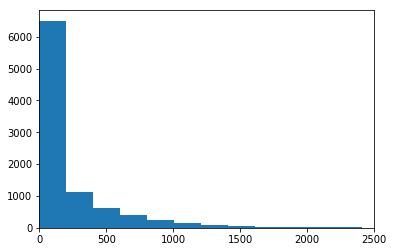

In [400]:
fig, ax = plt.subplots()
ax.hist(nyt_articles.commentCount, bins=30)
ax.set_xlim([0,2500])

### Comments

#### Fields

In [85]:
nyt_comments['commentWordCount'] = nyt_comments.commentBody\
                                               .apply(lambda s: len(s.split()))
idx_unique_users = nyt_comments.userID.drop_duplicates().index.tolist()

In [146]:
nyt_comments.describe(include=['O']).transpose()

count   unique  \
articleID              2176364     9450   
commentBody            2176364  2109650   
commentTitle           2099561        1   
commentType            2176364        3   
newDesk                2176364       44   
parentUserDisplayName   580297    59637   
permID                 2176342  2118572   
picURL                 2176364    14010   
sectionName            2026751       63   
status                 2176364        1   
typeOfMaterial         2176364       14   
userDisplayName        2175687   174700   
userLocation           2175860    46968   
userTitle                  325       43   
userURL                     23        7   

                                                                     top  \
articleID                                       58b0894195d0e0247463875e   
commentBody                                                   Well said.   
commentTitle                                                       <br/>   
commentType                                                      comment   
newDesk                                                             OpEd   
parentUserDisplayName                                   Richard Luettgen   
permID                                                          21676260   
picURL                 https://graphics8.nytimes.com/images/apps/time...   
sectionName                                                      Unknown   
status                                                          approved   
typeOfMaterial                                                      News   
userDisplayName                                                     John   
userLocation                                                         NYC   
userTitle                                           Your Money columnist   
userURL                http://www.nytimes.com/column/the-walking-dead...   

                          freq  
articleID                 6024  
commentBody                173  
commentTitle           2099561  
commentType            1595760  
newDesk                 767941  
parentUserDisplayName     3682  
permID                       2  
picURL                 1688359  
sectionName            1133382  
status                 2176364  
typeOfMaterial         1187581  
userDisplayName          10951  
userLocation             64668  
userTitle                   60  
userURL                     11

In [147]:
nyt_comments.describe().transpose()

count          mean           std           min  \
approveDate       2176364.0  1.503045e+09  1.532547e+07  1.483318e+09   
articleWordCount  2176364.0  1.265962e+03  8.794446e+02  1.100000e+01   
commentID         2176364.0  2.373128e+07  2.200550e+06  2.096371e+07   
commentSequence   2176364.0  2.373128e+07  2.200549e+06  2.096371e+07   
createDate        2176364.0  1.503035e+09  1.532598e+07  1.483314e+09   
depth             2176364.0  1.270584e+00  4.529281e-01  1.000000e+00   
editorsSelection  2176364.0  1.910204e-02  1.368838e-01  0.000000e+00   
inReplyTo         2176364.0  6.343940e+06  1.057828e+07  0.000000e+00   
parentID          2176364.0  6.343972e+06  1.057830e+07  0.000000e+00   
printPage         2176364.0  9.099801e+00  1.079504e+01  0.000000e+00   
recommendations   2176364.0  1.973701e+01  1.052103e+02  0.000000e+00   
recommendedFlag         0.0           NaN           NaN           NaN   
replyCount        2176364.0  4.350012e-01  2.260070e+00 -1.280000e+02   
reportAbuseFlag         0.0           NaN           NaN           NaN   
sharing           2176364.0  8.532948e-02  2.793714e-01  0.000000e+00   
timespeople       2176364.0  9.642128e-01  1.857593e-01  0.000000e+00   
trusted           2176364.0  3.461324e-02  1.827982e-01  0.000000e+00   
updateDate        2176364.0  1.503046e+09  1.532495e+07  1.483318e+09   
userID            2176364.0  5.001905e+07  2.344529e+07  1.045000e+03   
commentWordCount  2176364.0  7.075589e+01  6.128195e+01  1.000000e+00   

                           25%           50%           75%           max  
approveDate       1.489169e+09  1.494797e+09  1.519525e+09  1.525233e+09  
articleWordCount  8.340000e+02  1.122000e+03  1.432000e+03  1.633600e+04  
commentID         2.176221e+07  2.249832e+07  2.610409e+07  2.694126e+07  
commentSequence   2.176221e+07  2.249832e+07  2.610409e+07  2.694126e+07  
createDate        1.489164e+09  1.494789e+09  1.519512e+09  1.525233e+09  
depth             1.000000e+00  1.000000e+00  2.000000e+00  5.000000e+00  
editorsSelection  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
inReplyTo         0.000000e+00  0.000000e+00  2.120032e+07  2.694099e+07  
parentID          0.000000e+00  0.000000e+00  2.120034e+07  2.694099e+07  
printPage         1.000000e+00  1.000000e+00  1.900000e+01  1.980000e+02  
recommendations   1.000000e+00  4.000000e+00  1.000000e+01  1.047200e+04  
recommendedFlag            NaN           NaN           NaN           NaN  
replyCount        0.000000e+00  0.000000e+00  0.000000e+00  6.680000e+02  
reportAbuseFlag            NaN           NaN           NaN           NaN  
sharing           0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
timespeople       1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
trusted           0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
updateDate        1.489170e+09  1.494799e+09  1.519526e+09  1.525233e+09  
userID            3.271695e+07  5.751992e+07  6.780320e+07  8.585631e+07  
commentWordCount  2.500000e+01  5.200000e+01  9.700000e+01  4.210000e+02

#### Frequent values

In [337]:
print("Most common user names")
_ = nyt_comments.loc[idx_unique_users]\
                .userDisplayName.dropna()\
                .str.lower()
pd.Series( " ".join(_).split() ).value_counts()[:30]

Most common user names


john       37171
david      26573
steve      20985
michael    19362
robert     17934
paul       17251
mark       15250
richard    14450
tom        14148
mike       13423
james      13423
bob        12203
the        12177
jim        12094
m          11998
chris      11694
susan      11305
joe        11205
b          11179
bill       10199
dan         9424
mary        9139
s           8957
peter       8916
in          8533
j           8488
smith       8485
william     8266
c           7635
dave        7233
dtype: int64

In [338]:
print("Most common user locations")
_ = nyt_comments.loc[idx_unique_users]\
                .userLocation.dropna()\
                .str.replace('[^\w\s]','')\
                .str.lower()
pd.Series( " ".join(_).split() ).value_counts()[:30]

Most common user locations


new           170965
ny            143168
york          121441
ca             81937
nyc            75009
san            49147
nj             48307
california     48032
ma             43074
city           39606
chicago        35946
boston         33340
seattle        30855
usa            30802
los            30668
ct             30282
nc             30272
pa             30257
brooklyn       29473
angeles        28843
florida        26890
washington     25808
francisco      25043
texas          24689
dc             24476
fl             24321
jersey         24296
canada         20394
the            19953
tx             19921
dtype: int64

#### Editors' selection

##### Editor's selection ratio vs article topic

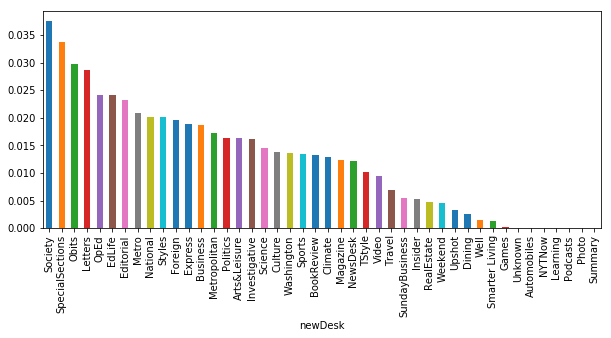

In [148]:
top_comments_topic = nyt_comments.groupby('newDesk')\
            .apply(lambda g: g.editorsSelection.sum() / g.shape[0])\
            .sort_values(ascending=False)
        
fig, ax = plt.subplots(figsize=(10,4))
top_comments_topic.plot(kind='bar', ax=ax)

##### Comment Word count vs editors' selection

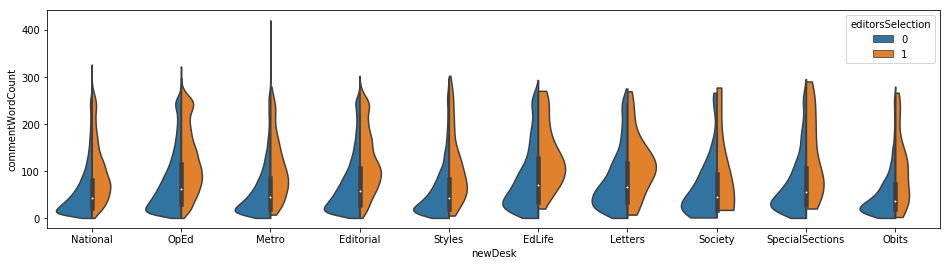

In [151]:
fig, ax = plt.subplots(figsize=(16,4))
plt_comm_topics = set(top_comments_topic[:10].index)
sns.violinplot(x='newDesk', y='commentWordCount', hue='editorsSelection',
               data=nyt_comments[nyt_comments.newDesk.isin(plt_comm_topics)],
               split=True, ax=ax, cut=0)

##### Gender inference

In [162]:
fnames = pd.read_csv("/data/2/virgile/us_names/census-dist-female-first.csv",
                     header=None, names=['Name', 'Prob', 'CumulProb', 'Rank'])
mnames = pd.read_csv("/data/2/virgile/us_names/census-dist-male-first.csv",
                     header=None, names=['Name', 'Prob', 'CumulProb', 'Rank'])

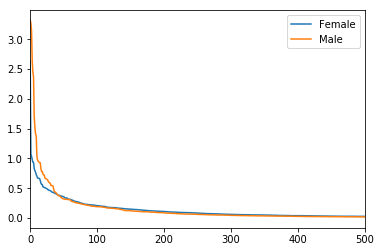

In [203]:
fig, ax = plt.subplots()
ax.plot(fnames.Prob, label='Female')
ax.plot(mnames.Prob, label='Male')
ax.set_xlim([0,500])
plt.legend();

In [198]:
fnames_set = set(fnames.Name.str.lower()) - set(mnames[mnames.Prob > .025].Name.str.lower())
mnames_set = set(mnames.Name.str.lower()) - set(fnames[fnames.Prob > .025].Name.str.lower())

In [199]:
len(fnames_set), len(mnames_set)

(4090, 1162)

In [224]:
def map_name_to_gender(names, mset, fset):
    ng_map = []
    for n in tqdm_notebook(names, leave=False):
        g = 'u'
        parts = n.lower().split()
        mparts = np.sum([_ in mset for _ in parts])
        fparts = np.sum([_ in fset for _ in parts])
        if mparts > fparts:
            g = 'm'
        elif fparts > mparts:
            g = 'f'
        ng_map.append({'Name': n, 'Gender': g})
    return pd.DataFrame(ng_map)

unique_names = nyt_comments.userDisplayName.dropna().unique()
ng_map = map_name_to_gender(unique_names, mnames_set, fnames_set)

HBox(children=(IntProgress(value=0, max=174700), HTML(value='')))

In [243]:
nyt_comments = nyt_comments.merge(ng_map, how='left',
                                  left_on='userDisplayName', right_on='Name')

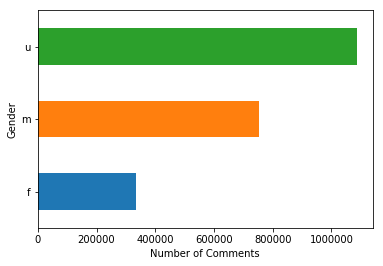

In [260]:
ax = nyt_comments.groupby('Gender').commentID.count().plot(kind='barh')
ax.set_xlabel("Number of Comments");

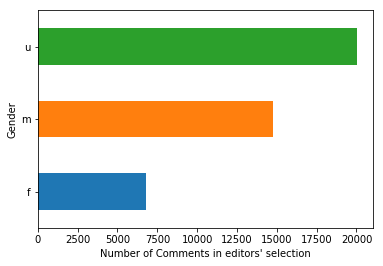

In [261]:
ax = nyt_comments.groupby('Gender').editorsSelection.sum().plot(kind='barh')
ax.set_xlabel("Number of Comments in editors' selection");

#### Predict editors' pick?

In [308]:
nyt = SimpleNamespace()
nyt.vec = CountVectorizer(min_df=5, stop_words='english')
nyt.limit = 50000
nyt.df = nyt_comments.sample(nyt.limit)
nyt.X = nyt.vec.fit_transform(nyt.df.commentBody)
nyt.features = np.array(nyt.vec.get_feature_names())
nyt.y = nyt.df.editorsSelection

In [312]:
cross_val_score(LogisticRegression(class_weight='balanced'), nyt.X, nyt.y,
                scoring='recall', cv=10)

array([0.07446809, 0.08510638, 0.03191489, 0.07526882, 0.06451613,
       0.07526882, 0.07526882, 0.05376344, 0.09677419, 0.05376344])

#### Predict gender?

In [342]:
nyt = SimpleNamespace()
nyt.vec = CountVectorizer(min_df=5, stop_words='english')
nyt.df = nyt_comments.dropna(subset=['Gender'])[nyt_comments.Gender != 'u'].sample(10000)
nyt.X = nyt.vec.fit_transform(nyt.df.commentBody)
nyt.features = np.array(nyt.vec.get_feature_names())
nyt.y = preprocessing.label_binarize(nyt.df.Gender, classes=['f', 'm']).flatten()

/home/virgile/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [345]:
nyt.lr = LogisticRegression(class_weight='balanced')
nyt.f1_list   = cross_val_score(nyt.lr, nyt.X, nyt.y, scoring='f1', cv=10)
nyt.prec_list = cross_val_score(nyt.lr, nyt.X, nyt.y, scoring='precision', cv=10)
nyt.rec_list = cross_val_score(nyt.lr, nyt.X, nyt.y, scoring='recall', cv=10)

In [347]:
print("Predicting gender")
for n, l in zip(['F1', 'Precision', 'Recall'], [nyt.f1_list, nyt.prec_list, nyt.rec_list]):
    print("{}: {:.2f} +/- {:.2f}".format(n, np.mean(l)*100, np.std(l)))

Predicting gender
F1: 70.28 +/- 0.01
Precision: 72.82 +/- 0.01
Recall: 67.93 +/- 0.01


## Yelp dataset 

Data from multiple confounders paper.

###  Load data

In [390]:
# workdir = "EDHvsWI_food_vs_notfood"
workdir = "EDHvsWI_gender_category"

yelp = SimpleNamespace()
with open("/data/2/virgile/confound/multiple/{}/reviews.json".format(workdir)) as fd:
    yelp.df = pd.DataFrame(json.loads(_) for _ in fd)

In [ ]:
yelp.vec = CountVectorizer(min_df=5, stop_words='english')
yelp.X = yelp.vec.fit_transform(tqdm_notebook(yelp.df.text, desc='Vectorizing', leave=False))
yelp.feature_names = np.array(yelp.vec.get_feature_names())
yelp.y = preprocessing.label_binarize(yelp.df.label, classes=[0., 1.])
yelp.c_gender = preprocessing.label_binarize(yelp.df.gender, classes=['female', 'male'])
yelp.c_category = preprocessing.label_binarize(yelp.df.category, classes=['not-food', 'food'])
# yelp.c_state = preprocessing.label_binarize(yelp.df.state, classes=['PA', 'NC'])

# Detecting drift experiments

## Create biased datasets

In [718]:
%run ../python/inject_bias_simple.py

In [976]:
biaslist_3 = [.1,.5,.9]
biaslist_5 = [.1,.3,.5,.7,.9]
biaslist = [.1,.2,.3,.4,.5,.6,.7,.8,.9]

yelp.bias_sets_category = create_trte_datasets(yelp.X, yelp.y, yelp.c_category,
                                               8000, biaslist, biaslist, k=5)
yelp.bias_sets_gender = create_trte_datasets(yelp.X, yelp.y, yelp.c_gender,
                                             8000, biaslist, biaslist, k=5)
clear_output()

## Detection methods

In [1157]:
%run ../python/drift_detection.py

In [1158]:
def drift_detection_expmt(X, y, z, z_cmps, z_names,
                          biased_sets,
                          methods, method_names):
    """
    Loops over the given training and testing datasets, computes statistics
    about confounding shift and run each drift detection method.
    """
    r = []
    # get train and test data
    tr_data = biased_sets[biased_sets.split == 'train']
    te_data = biased_sets[biased_sets.split == 'test']
    
    # loop over the training data
    for i, tr_row in tqdm_notebook(list(tr_data.iterrows()), leave=False):
        X_tr = X[tr_row.indices]
        y_tr = y[tr_row.indices]
        z_tr = z[tr_row.indices]
        z_cmps_tr = [z_cmp[tr_row.indices] for z_cmp in z_cmps]
        clf = LogisticRegression(class_weight='balanced').fit(X_tr, y_tr)
        # loop over the testing data
        for j, te_row in te_data.iterrows():
            X_te = X[te_row.indices]
            y_te = y[te_row.indices]
            z_te = z[te_row.indices]
            z_cmps_te = [z_cmp[te_row.indices] for z_cmp in z_cmps]
            # get data independent of the method used
            base_entry = {}
            for k, v in tr_row.items():
                base_entry['tr_' + k] = v
            for k, v in te_row.items():
                base_entry['te_' + k] = v
            base_entry['corr_diff'] = base_entry['tr_corr_yz'] - base_entry['te_corr_yz']
            base_entry['corr_diff_round'] = np.around(base_entry['corr_diff'], 1)
            base_entry['abs_corr_diff'] = np.abs(base_entry['corr_diff'])
            base_entry['abs_corr_diff_round'] = np.around(base_entry['abs_corr_diff'], 1)
            # run every method and get the drift detection value returned
            for method, name in zip(methods, method_names):
                for z_cmp_tr, z_cmp_te, z_name in zip(z_cmps_tr, z_cmps_te, z_names):
                    drift_val = method(X_tr, y_tr, z_tr, X_te, y_te, z_te,
                                       z_cmp_tr, z_cmp_te, clf)
                    method_entry = copy(base_entry)
                    method_entry.update({
                        'method': name,
                        'drift': drift_val,
                        'z_cmp': z_name
                    })
                    r.append(method_entry)
    return pd.DataFrame(r)

In [1322]:
methods = [
    pxgz_diff_hd,
    pxgz_diff_jsd,
    clf_confidence_distrib,
]
method_names = [_.__qualname__ for _ in methods]

z_names = ['c_category', 'c_gender']
zs = [yelp.__dict__[z_name] for z_name in z_names]

yelp.results_gender = drift_detection_expmt(yelp.X, yelp.y.flatten(), yelp.c_gender,
                                            zs, z_names,
                                            yelp.bias_sets_gender,
                                            methods, method_names)


yelp.results_category = drift_detection_expmt(yelp.X, yelp.y.flatten(), yelp.c_category,
                                              zs, z_names,
                                              yelp.bias_sets_category,
                                              methods, method_names)
# clear_output()

HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

In [1323]:
def compute_nodrift_value(results):
    keep = results.abs_corr_diff_round == 0
    nodrift_val = results[keep].groupby(['method', 'z_cmp']).mean().drift.to_dict()
    results['drift_no_bias'] = results.apply(lambda r: nodrift_val[(r.method, r.z_cmp)], axis=1)
    results['drift_perc_change'] = (results.drift - results.drift_no_bias) / results.drift_no_bias
    return results

yelp.results_gender = compute_nodrift_value(yelp.results_gender)
yelp.results_category = compute_nodrift_value(yelp.results_category)

## Results

In [1325]:
def ols_plot(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    color = kwargs.pop("color")
    mod = sm.OLS(data[y], sm.add_constant(data[x]))
    res = mod.fit()
    
    m, M = ax.get_xlim()
    intercept, coef = res.params.const, res.params[x]
    ax.plot([m,M],[intercept, coef*M + intercept], color=color)
    
    eq_str = "${:.2e}x + {:.2e}$".format(coef, intercept)
    pearson_str = "$\\rho = {:.2e}$"\
                  .format(pearsonr(data[x], data[y])[0])
    r2_str = "$R^2 = {:.2e}$".format(res.rsquared)
    ax.text(.01, 1, "\n".join([eq_str, r2_str, pearson_str]),
            transform=ax.transAxes, fontsize=10,
            va='top', ha='left')
    ax.set_xlim(m, M)

### When we induce confounding shift due to gender

/home/virgile/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


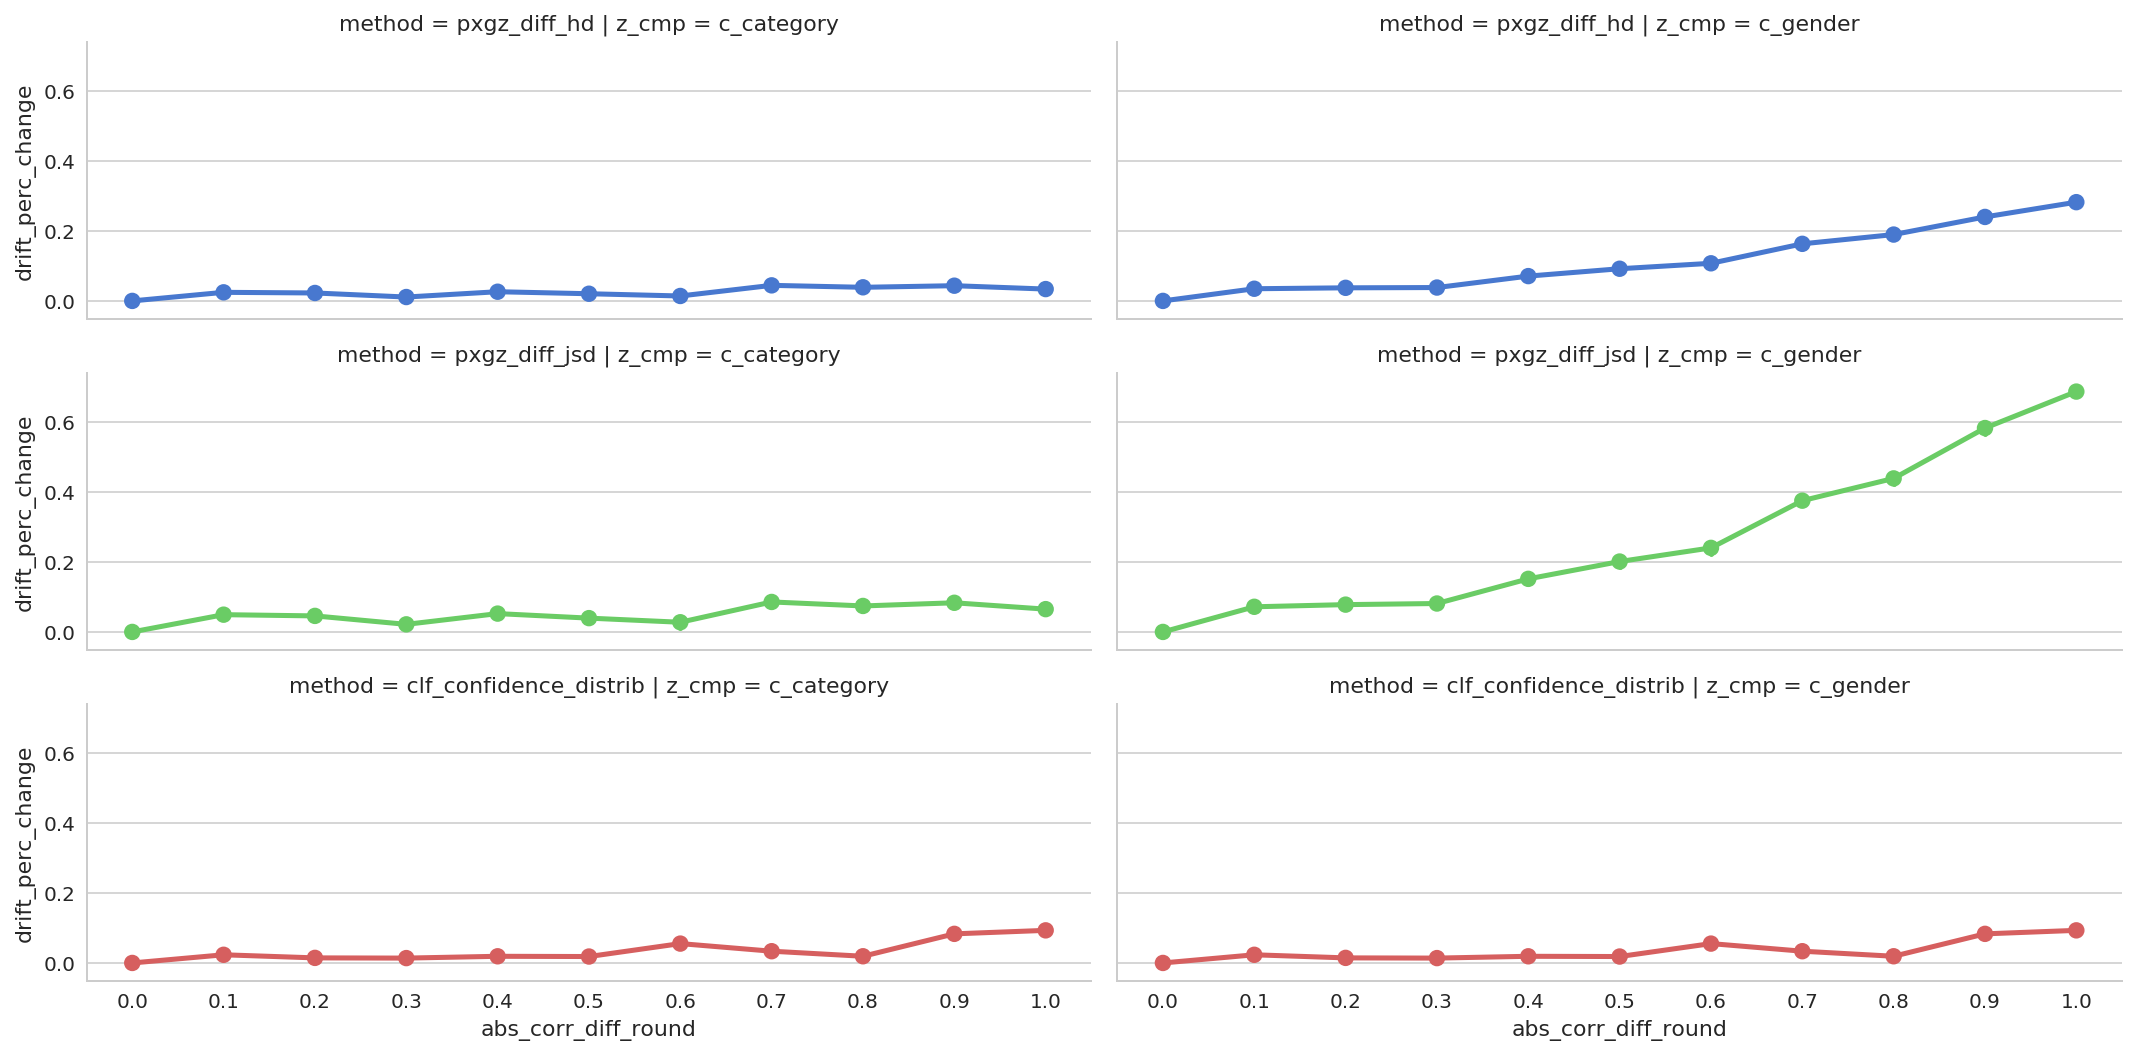

In [1327]:
g = sns.FacetGrid(yelp.results_gender, hue='method',
                  row='method', col='z_cmp',
                  sharex=True, sharey=True, aspect=3, size=2.5)
g.map(sns.pointplot, 'abs_corr_diff_round', 'drift_perc_change');

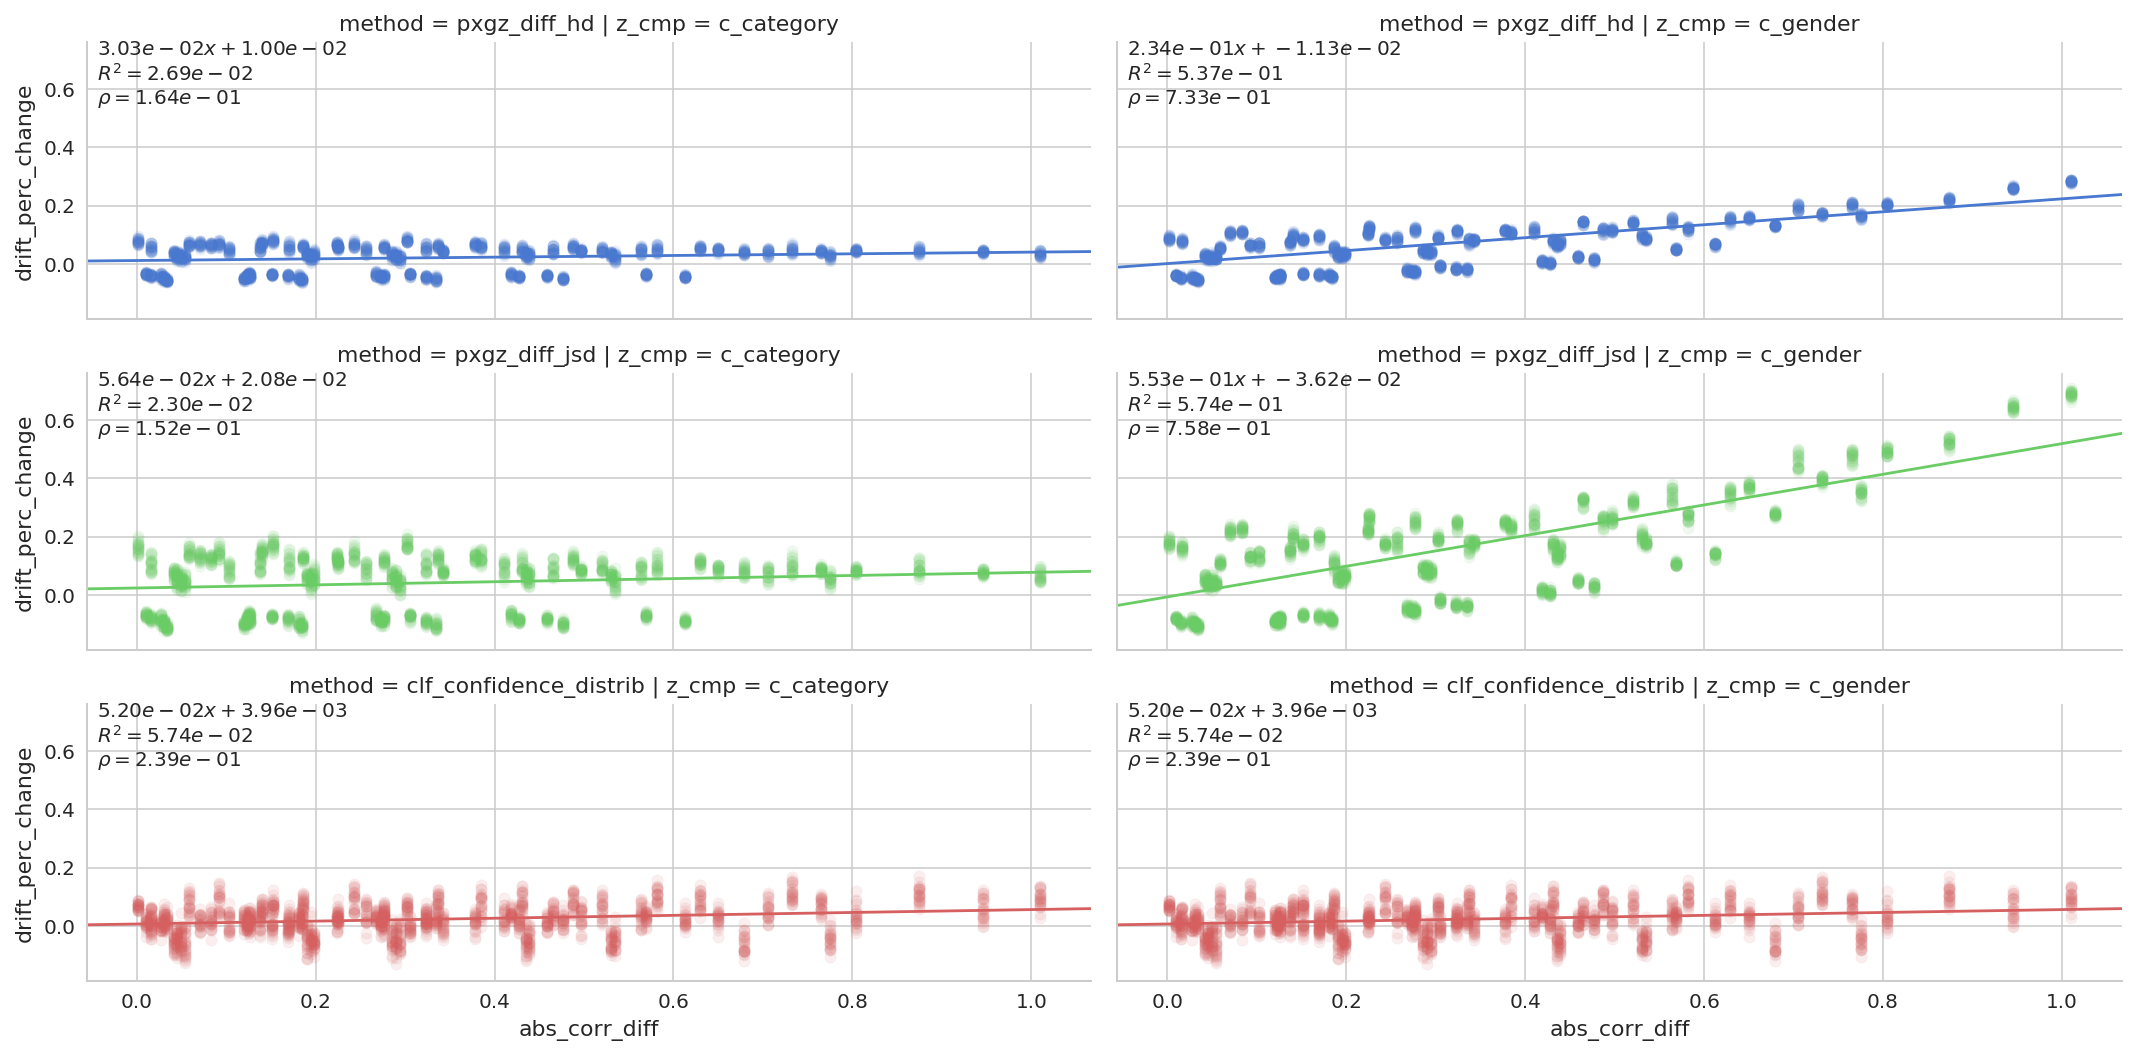

In [1328]:
g = sns.FacetGrid(yelp.results_gender, row='method', hue='method', col='z_cmp',
                  sharex=True, sharey=True, aspect=3, size=2.5)
g.map(plt.scatter, 'abs_corr_diff', 'drift_perc_change', alpha=.1)
g.map_dataframe(ols_plot, 'abs_corr_diff', 'drift_perc_change');

### When we induce confounding shift due to category

/home/virgile/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


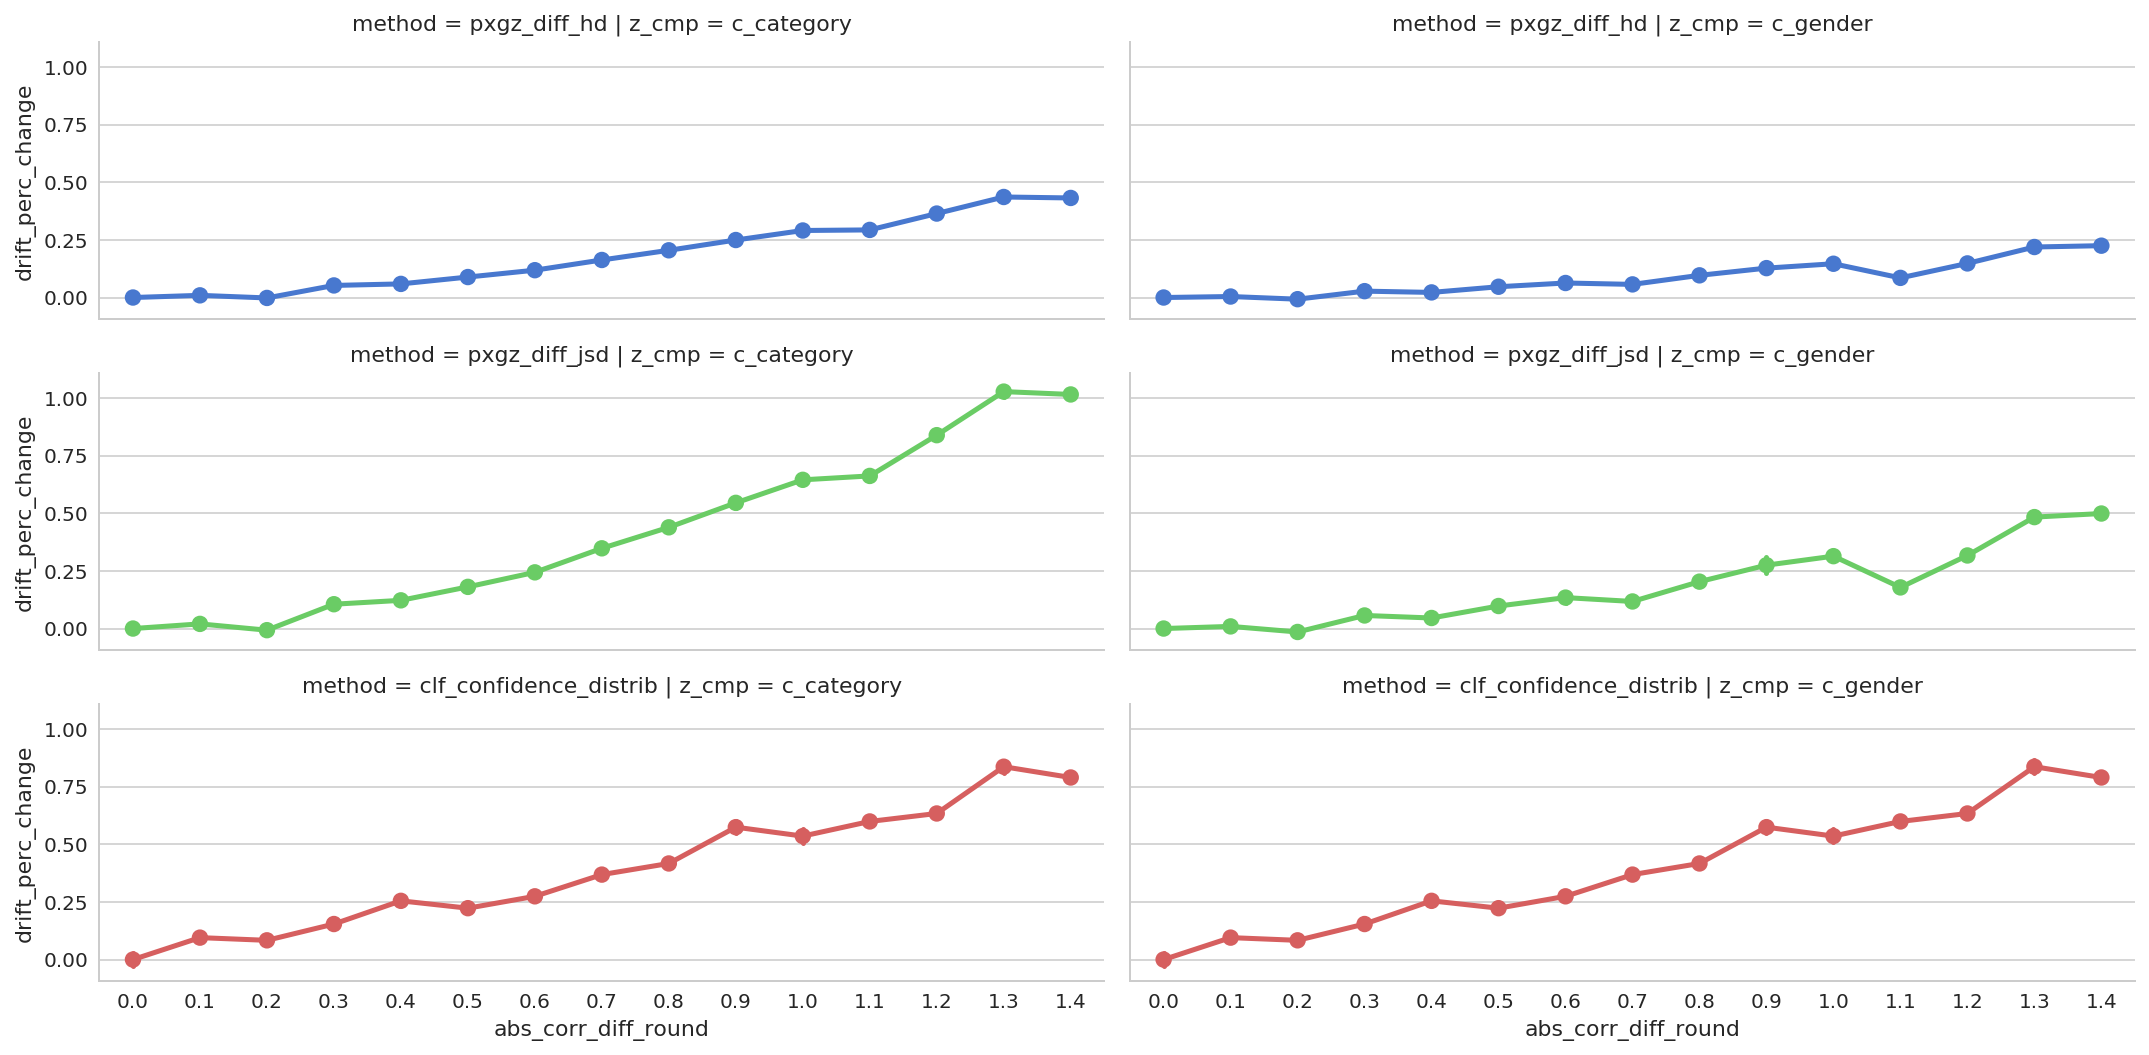

In [1324]:
g = sns.FacetGrid(yelp.results_category, hue='method',
                  row='method', col='z_cmp',
                  sharex=True, sharey=True, aspect=3, size=2.5)
g.map(sns.pointplot, 'abs_corr_diff_round', 'drift_perc_change');

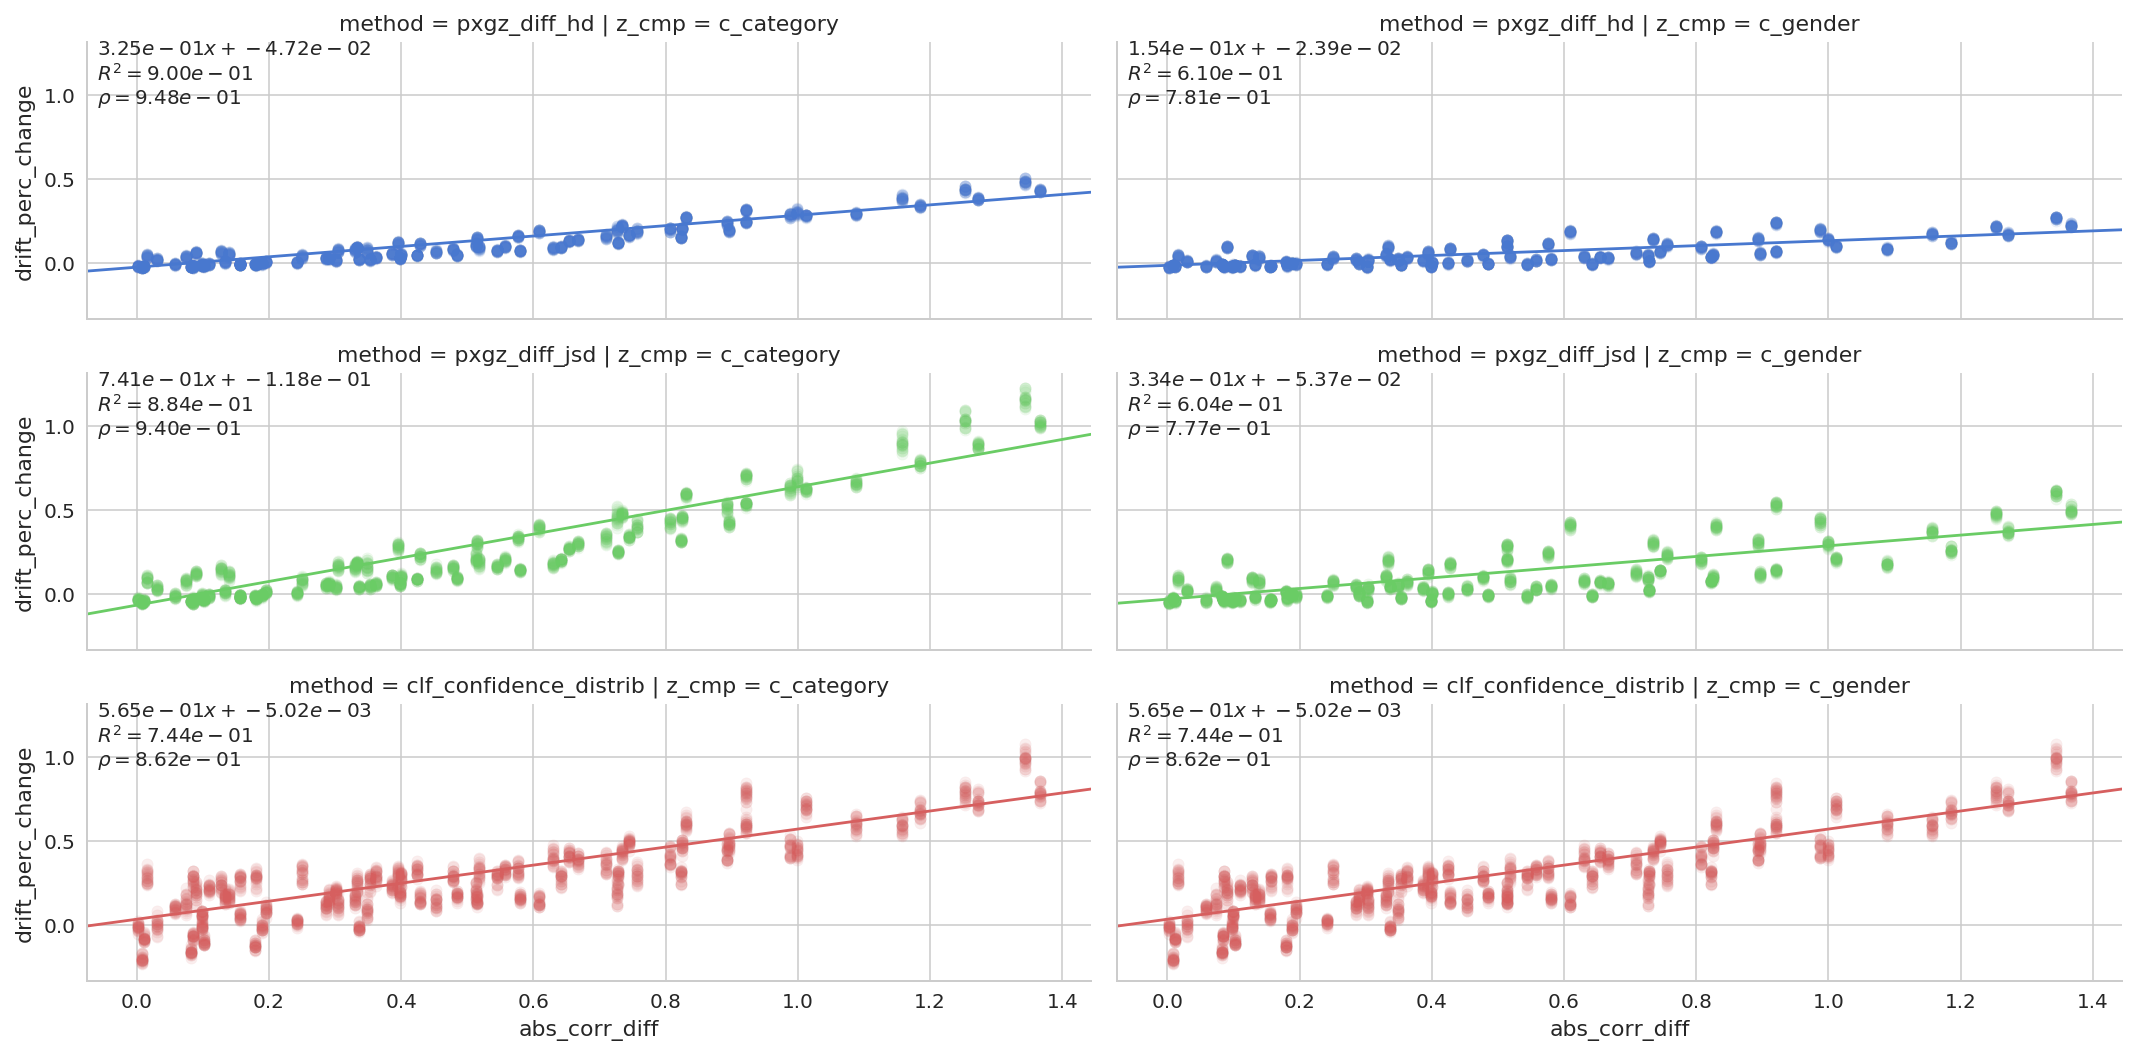

In [1326]:
g = sns.FacetGrid(yelp.results_category, row='method', hue='method', col='z_cmp',
                  sharex=True, sharey=True, aspect=3, size=2.5)
g.map(plt.scatter, 'abs_corr_diff', 'drift_perc_change', alpha=.1)
g.map_dataframe(ols_plot, 'abs_corr_diff', 'drift_perc_change');

# Running LDA on Yelp data

In [1354]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [1773]:
yelp.lda = LatentDirichletAllocation(200, n_jobs=1)

In [1774]:
%%time
yelp.ldaX = yelp.lda.fit_transform(yelp.X)

CPU times: user 45min 6s, sys: 1h 37min 58s, total: 2h 23min 4s
Wall time: 35min 53s


In [1776]:
def lda_vs_X_expmt(X, Xlda, y, z, biased_sets):
    """
    Loops over the given training and testing datasets, computes statistics
    about confounding shift and run each drift detection method.
    """
    r = []
    # get train and test data
    tr_data = biased_sets[biased_sets.split == 'train']
    te_data = biased_sets[biased_sets.split == 'test']
    # loop over the training data
    for i, tr_row in tqdm_notebook(list(tr_data.iterrows()), leave=False):
        X_tr = X[tr_row.indices]
        Xlda_tr = Xlda[tr_row.indices]
#         both_tr = sp.hstack([X_tr, Xlda_tr])
        y_tr = y[tr_row.indices]
        z_tr = z[tr_row.indices]
        clf_fitted = [LogisticRegression(class_weight='balanced').fit(d, y_tr)
                      for d in [X_tr, Xlda_tr]]#, both_tr]]
        clf_names = ['fit on X', 'fit on LDA(X)']#, 'fit on both']
        # loop over the testing data
        for j, te_row in te_data.iterrows():
            X_te = X[te_row.indices]
            Xlda_te = Xlda[te_row.indices]
#             both_te = sp.hstack([X_te, Xlda_te])
            y_te = y[te_row.indices]
            z_te = z[te_row.indices]
            # get data independent of the method used
            base_entry = {}
            for k, v in tr_row.items():
                base_entry['tr_' + k] = v
            for k, v in te_row.items():
                base_entry['te_' + k] = v
            base_entry['corr_diff'] = base_entry['tr_corr_yz'] - base_entry['te_corr_yz']
            base_entry['corr_diff_round'] = np.around(base_entry['corr_diff'], 1)
            base_entry['abs_corr_diff'] = np.abs(base_entry['corr_diff'])
            base_entry['abs_corr_diff_round'] = np.around(base_entry['abs_corr_diff'], 1)
            # run every method and get the drift detection value returned
            for clf, name, d_te in zip(clf_fitted, clf_names, [X_te, Xlda_te]):
                y_proba = clf.predict_proba(d_te)
                y_pred = y_proba.argmax(axis=1)
                method_entry = copy(base_entry)
                method_entry.update({
                    'clf': name,
                    'y_proba': y_proba,
                    'y_pred': y_pred,
                    'y_true': y_te,
                    'f1_score': metrics.f1_score(y_te, y_pred)
                })
                r.append(method_entry)
    return pd.DataFrame(r)

In [1777]:
yelp.lda_results_category = lda_vs_X_expmt(yelp.X, yelp.ldaX, yelp.y.flatten(),
                                           yelp.c_category.flatten(),
                                           yelp.bias_sets_category)

HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

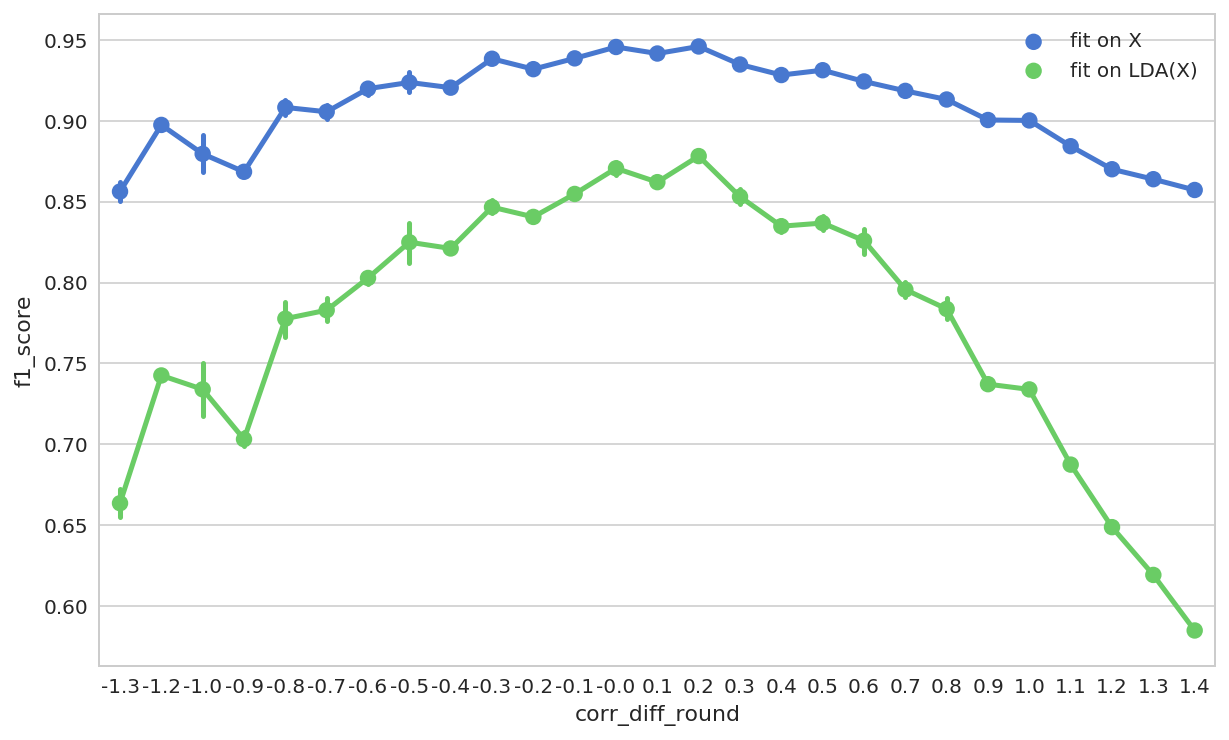

In [1778]:
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(x='corr_diff_round', y='f1_score', hue='clf',
              data=yelp.lda_results_category, ax=ax)
plt.legend()

In [1742]:
def cont_hd(s1, s2, nbins=1000):
    bins = np.linspace(0,1,nbins+1)
    s1p, _ = np.histogram(s1, bins=bins)
    s2p, _ = np.histogram(s2, bins=bins)
    s1p = s1p / s1p.sum()
    s2p = s2p / s2p.sum()
    
    return hd(s1p, s2p)

In [1786]:
def get_topics_hd(X_tr, X_te, nbins=100):
    assert X_tr.shape[1] == X_te.shape[1]
    distrib_test = [cont_hd(X_tr[:,i], X_te[:,i], nbins=nbins)
                    for i in range(X_tr.shape[1])]
    return distrib_test

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

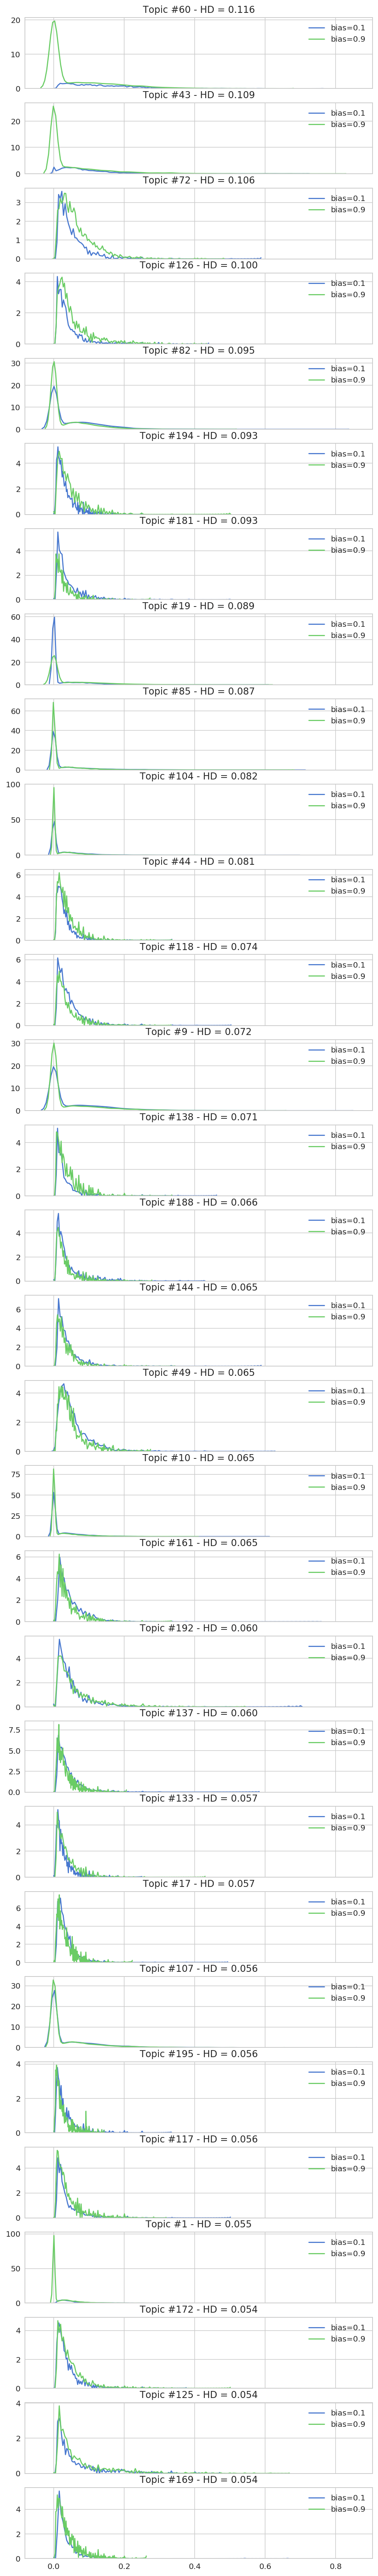

In [1784]:
t1 = yelp.ldaX[yelp.bias_sets_category.iloc[0].indices] # bias = 0.1
t2 = yelp.ldaX[yelp.bias_sets_category.iloc[-1].indices] # bias = 0.9
nbins = 100
n_components = 30
fig, ax = plt.subplots(nrows=n_components, figsize=(8,n_components*2), sharex=True)
distrib_test = get_topics_hd(t1, t2)
for i, j in enumerate(np.argsort(distrib_test)[::-1][:n_components]):
    sns.kdeplot(t1[:,j], ax=ax[i], label='bias=0.1')
    sns.kdeplot(t2[:,j], ax=ax[i], label='bias=0.9')
    
    ax[i].set_title('Topic #{} - HD = {:.3f}'.format(j+1, distrib_test[j]))
plt.legend()

In [ ]:
t = []
for i, r in tqdm_notebook(yelp.lda_results_category.iterrows()):
    t.append(get_topics_hd(yelp.ldaX[r.tr_indices], yelp.ldaX[r.te_indices]))
yelp.lda_results_category['topics_hd'] = t

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [1791]:
t = pd.DataFrame(yelp.lda_results_category.topics_hd.tolist())

In [1792]:
t['corr_diff_round'] = yelp.lda_results_category.corr_diff_round
t['f1_score'] = yelp.lda_results_category.f1_score

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

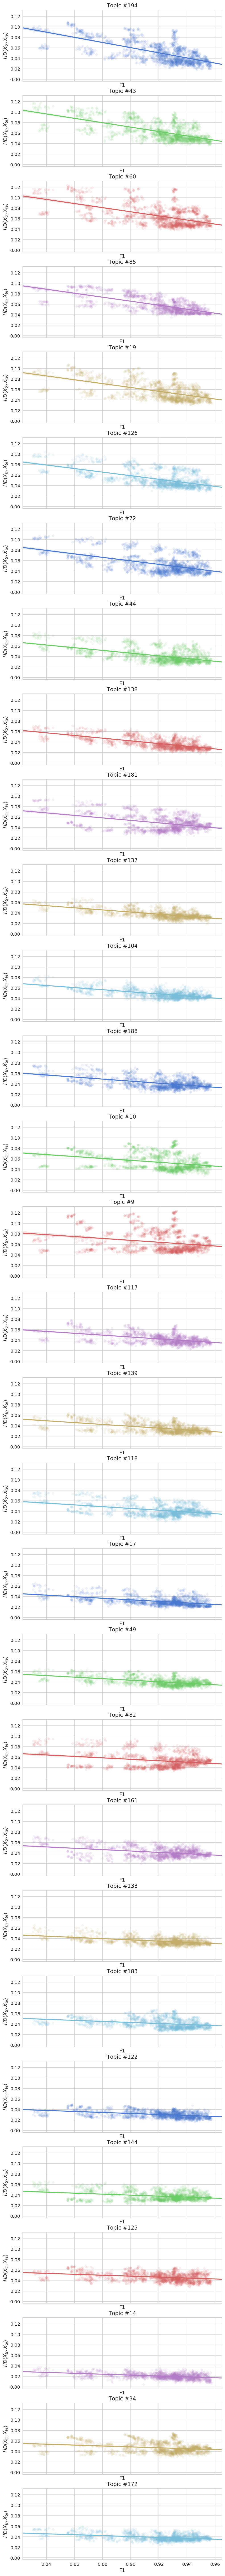

In [1798]:
n_components = yelp.lda.n_components
n_plot = 30
xdata = t[::2].f1_score
ydata = [t[::2][i] for i in range(n_components)]

reg_coef = [
    sm.OLS(y, sm.add_constant(xdata)).fit_regularized().params[1]
    for y in tqdm_notebook(ydata, leave=False)
]

fig, ax = plt.subplots(n_plot, figsize=(8,int(n_plot*3.5)), sharex=True, sharey=True)
topic_order = np.argsort(np.abs(reg_coef))[::-1]

for axi, ti in enumerate(topic_order[:n_plot]):
    y = ydata[ti]
    sns.regplot(x=xdata, y=y, ax=ax[axi],
                marker='o', scatter_kws=dict(alpha=.1))
    ax[axi].set_xlabel('F1')
    ax[axi].set_ylabel('$HD(X_{tr}, X_{te})$')
    ax[axi].set_title('Topic #{}'.format(ti+1))

In [1775]:
pyLDAvis.sklearn.prepare(yelp.lda, yelp.X, yelp.vec, sort_topics=False, n_jobs=1)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
0      1.622023        1       1  0.205249 -0.221423
1      0.011273        1       2 -0.275000 -0.032389
2      0.019892        1       3 -0.136559  0.010651
3      0.706532        1       4  0.167694 -0.002709
4      0.377487        1       5  0.147990  0.057420
5      0.013830        1       6 -0.223593 -0.015885
6      0.014850        1       7 -0.206896 -0.010715
7      0.024589        1       8 -0.106219  0.019550
8      5.515523        1       9  0.192587 -0.275397
9      2.631475        1      10  0.177511 -0.103210
10     0.303300        1      11  0.142308  0.069547
11     0.031399        1      12 -0.042126  0.037397
12     0.016303        1      13 -0.184452 -0.003815
13     0.041999        1      14 -0.003314  0.047155
14     0.014614        1      15 -0.214740 -0.013110
15     0.018503        1      16 -0.156176  0.004767
16     0.684596        1      17  0.160005  0.040479
17     0.322418        1      18  0.144000  0.059461
18     5.436121        1      19  0.199939 -0.293848
19     0.020213        1      20 -0.133547  0.011537
20     0.751719        1      21  0.166939  0.021065
21     0.957562        1      22  0.172182  0.015711
22     0.013844        1      23 -0.225533 -0.016524
23     0.921071        1      24  0.165395 -0.002271
24     0.022754        1      25 -0.108843  0.018789
25     0.436494        1      26  0.148294  0.063422
26     0.392146        1      27  0.147312  0.063619
27     0.014233        1      28 -0.216252 -0.013603
28     1.398043        1      29  0.179854 -0.089052
29     0.177529        1      30  0.115515  0.067451
30     0.017781        1      31 -0.158132  0.004181
31     0.017716        1      32 -0.158641  0.004015
32     0.011597        1      33 -0.270026 -0.030699
33     0.927853        1      34  0.175480 -0.042104
34     0.016528        1      35 -0.175855 -0.001192
35     0.019128        1      36 -0.152658  0.005845
36     0.014842        1      37 -0.205028 -0.010123
37     0.012797        1      38 -0.231624 -0.018429
38     0.680505        1      39  0.161326  0.031239
39     0.054877        1      40  0.034587  0.055915
40     0.020724        1      41 -0.125435  0.013933
41     0.251856        1      42  0.133409  0.067298
42     2.892711        1      43  0.220099 -0.227716
43     0.767765        1      44  0.162084  0.026810
44     0.020159        1      45 -0.132610  0.011815
45     0.021474        1      46 -0.123280  0.014571
46     0.014610        1      47 -0.200922 -0.008887
47     0.021153        1      48 -0.128514  0.013024
48     1.257972        1      49  0.179284 -0.076782
49     0.013616        1      50 -0.227356 -0.017084
50     0.012857        1      51 -0.251412 -0.024691
51     0.340545        1      52  0.146396  0.066432
52     0.014089        1      53 -0.223154 -0.015746
53     0.013145        1      54 -0.233157 -0.018881
54     0.252651        1      55  0.136393  0.069577
55     0.022030        1      56 -0.117572  0.016250
56     0.016183        1      57 -0.178820 -0.002107
57     0.066286        1      58  0.045818  0.057987
58     0.015926        1      59 -0.191467 -0.005969
59     6.877768        1      60  0.175533 -0.173444
60     0.018016        1      61 -0.168105  0.001188
61     0.011622        1      62 -0.266328 -0.029494
62     0.371087        1      63  0.148316  0.059718
63     0.475407        1      64  0.157500  0.057600
64     0.165729        1      65  0.113633  0.067723
65     0.013539        1      66 -0.226110 -0.016668
66     0.015791        1      67 -0.191101 -0.005842
67     0.375854        1      68  0.150002  0.051948
68     0.790812        1      69  0.165261  0.016589
69     0.610075        1      70  0.162452  0.031483
70     0.223827        1      71  0.127816  0.068388
71     1.550232        1      72  0.186248 -0.103774
72     0.019578        1      73 -0.150934  0.0